# Imports

In [12]:
import csv
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pingouin as pg 
import re
from scipy.special import binom
import scipy.stats as st
from scipy.stats import pearsonr, spearmanr, kendalltau
import seaborn as sns
import statsmodels as sm
from williams import williams_test
from fdr import false_discovery_control2
from irrCAC.raw import CAC

In [13]:
def set_size(width=505, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

# Data visualization

In [17]:
ANNOTATIONS_DF = pd.read_csv("hanna_stories_annotations.csv")
METRICS_DF = pd.read_csv("hanna_metric_scores_llm.csv", index_col="Model")

In [18]:
CORRELATIONS = {
    "pearson": pearsonr,
    "spearman": spearmanr,
    "kendall": kendalltau
}
CORRELATION_TYPES = ["overall", "system"]

CRITERIA = ['Relevance', 'Coherence', 'Empathy', 'Surprise', 'Engagement', 'Complexity']
CRITERIA_LABELS = ["RE", "CH", "EM", "SU", "EG", "CX"]

N_STORIES = 96

MODELS = [
    "Human",
    "BertGeneration",
    "CTRL",
    "GPT",
    "GPT-2 (tag)",
    "GPT-2",
    "RoBERTa",
    "XLNet",
    "Fusion",
    "HINT",
    "TD-VAE"
]
NEW_MODELS = [
    "LlamaChat-7b",
    "OrcaMistral-7b",
    "Beluga-13b",
    "OrcaPlatypus-13b",
    "LlamaInstruct-30b",
    "Platypus2-70b"
]

In [20]:
METRICS_DF

,Relevance,Coherence,Empathy,Surprise,Engagement,Complexity,BLEU Ξ§,ROUGE-1 Recall Ξ§,ROUGE-1 Precision Ξ§,ROUGE-1 F-Score Ξ§,...,ChatGPT EG 3,ChatGPT CX 3,ChatGPT AVG 3,ChatGPT RE 4,ChatGPT CH 4,ChatGPT EM 4,ChatGPT SU 4,ChatGPT EG 4,ChatGPT CX 4,ChatGPT AVG 4
Model,,,,,,,,,,,,,,,,,,,,,
Human,"[3.6666666666666665, 5.0, 4.666666666666667, 3...","[3.6666666666666665, 4.666666666666667, 4.6666...","[2.3333333333333335, 4.0, 4.0, 3.0, 3.0, 3.333...","[2.3333333333333335, 3.6666666666666665, 4.333...","[3.3333333333333335, 3.6666666666666665, 4.0, ...","[2.6666666666666665, 4.0, 4.333333333333333, 4...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",...,"[1.6666666666666667, 3.0, 3.0, 3.0, 3.0, 3.0, ...","[2.0, 3.3333333333333335, 3.3333333333333335, ...","[1.9444444444444444, 2.8333333333333335, 2.833...","[4.666666666666667, 5.0, 4.0, 4.33333333333333...","[4.0, 4.0, 4.0, 4.0, 5.0, 4.0, 4.0, 4.0, 3.0, ...","[3.3333333333333335, 4.0, 4.0, 4.0, 4.0, 4.0, ...","[3.6666666666666665, 3.0, 3.6666666666666665, ...","[3.3333333333333335, 4.0, 4.0, 4.0, 3.0, 4.0, ...","[3.3333333333333335, 3.0, 3.3333333333333335, ...","[3.722222222222222, 3.8333333333333335, 3.8333..."
BertGeneration,"[1.6666666666666667, 3.0, 1.3333333333333333, ...","[3.6666666666666665, 2.6666666666666665, 2.333...","[2.6666666666666665, 2.6666666666666665, 1.0, ...","[1.3333333333333333, 2.0, 1.6666666666666667, ...","[2.6666666666666665, 2.6666666666666665, 1.333...","[2.6666666666666665, 2.6666666666666665, 1.333...","[1.4336111822, 1.4493826988, 0.1779090484, 0.1...","[0.38249, 0.24074, 0.16285, 0.13276, 0.40645, ...","[0.37054, 0.26639, 0.59259, 0.56771, 0.26923, ...","[0.37642, 0.25292, 0.25549, 0.2152, 0.32391, 0...",...,"[1.3333333333333333, 1.0, 1.0, 2.6666666666666...","[3.0, 1.6666666666666667, 2.6666666666666665, ...","[1.5555555555555554, 1.1666666666666667, 2.277...","[3.6666666666666665, 1.6666666666666667, 1.0, ...","[3.3333333333333335, 2.0, 1.0, 2.0, 1.33333333...","[4.0, 1.0, 1.0, 1.0, 1.0, 2.3333333333333335, ...","[2.6666666666666665, 1.0, 1.0, 1.3333333333333...","[3.5, 1.6666666666666667, 1.0, 2.0, 1.33333333...","[3.0, 2.3333333333333335, 1.0, 2.0, 1.0, 2.0, ...","[3.3611111111111107, 1.6111111111111114, 1.0, ..."
CTRL,"[2.3333333333333335, 3.6666666666666665, 2.666...","[3.0, 3.3333333333333335, 3.3333333333333335, ...","[2.3333333333333335, 3.3333333333333335, 3.333...","[2.6666666666666665, 1.3333333333333333, 3.0, ...","[2.6666666666666665, 3.3333333333333335, 3.333...","[2.6666666666666665, 3.0, 3.0, 2.3333333333333...","[1.2558030838, 2.775216509, 0.400491848, 0.271...","[0.29954, 0.30741, 0.18702, 0.19367, 0.23871, ...","[0.38922, 0.3547, 0.54444, 0.60456, 0.30833, 0...","[0.33854, 0.32937, 0.27841, 0.29336, 0.26909, ...",...,"[1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, ...","[1.3333333333333333, 1.3333333333333333, 2.0, ...","[1.222222222222222, 1.111111111111111, 1.16666...","[1.0, 1.6666666666666667, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 2.3333333333333335, ...","[1.0, 1.3333333333333333, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.1666666666666667, 1.0, 1.0, 1.0, 1.222..."
GPT,"[3.6666666666666665, 3.0, 2.6666666666666665, ...","[3.6666666666666665, 3.0, 2.3333333333333335, ...","[3.0, 2.3333333333333335, 2.6666666666666665, ...","[3.0, 2.3333333333333335, 1.3333333333333333, ...","[3.0, 3.0, 2.0, 2.3333333333333335, 3.0, 3.0, ...","[2.6666666666666665, 3.0, 2.3333333333333335, ...","[0.9493520114, 2.3140339956, 0.1505541131, 0.2...","[0.24424, 0.3037, 0.1374, 0.05359, 0.34194, 0....","[0.29944, 0.36771, 0.5567, 0.72131, 0.26633, 0...","[0.26904, 0.33265, 0.2204, 0.09977, 0.29944, 0...",...,"[1.0, 1.0, 1.0, 1.0, 2.0

In [23]:
GRADES_LABELS = ["{} {} {}".format(m, c, i) for m in ["Beluga-13B", "Llama-13B", "Mistral-7B", "ChatGPT"] for i in [1,2,3,4] for c in CRITERIA_LABELS]

HUMAN_LABELS = []
for i in range(3):
    for c in CRITERIA_LABELS:
        HUMAN_LABELS.append("Human {} {}".format(i+1, c))
        
LABELS_CLEAN_1 = ["Human"] + [" "] + ["Beluga-13B {}".format(i) for i in [1,2,3,4]] + ["Llama-13B {}".format(i) for i in [1,2,3,4]] + ["Mistral-7B {}".format(i) for i in [1,2,3,4]] + ["ChatGPT {}".format(i) for i in [1,2,3,4]]
LABELS_CLEAN_ALL = ["Human"] + [" "] + ["Beluga-13B {}".format(i) for i in [1]] + ["Llama-13B {}".format(i) for i in [1]] + ["Mistral-7B {}".format(i) for i in [1]] + ["ChatGPT {}".format(i) for i in [1]]
LABELS_CLEAN_SHORT = ["Human"] + [" "] + ["B-13B {}".format(i) for i in [1,2,3,4]] + ["L-13B {}".format(i) for i in [1,2,3,4]] + ["M-7B {}".format(i) for i in [1,2,3,4]] + ["Chat {}".format(i) for i in [1,2,3,4]]

In [24]:
METRICS = METRICS_DF.columns[6:].tolist()
METRICS_LABELS = METRICS

METRICS_FILTERED = HUMAN_LABELS + GRADES_LABELS + [
    "BLEU Ξ§", "ROUGE-1 Recall Ξ§",
    "METEOR Ξ§", "chrF Ξ§", "ROUGE-WE-3 Recall Ξε", "BERTScore F1 Ξε",
    "MoverScore Ξε", "DepthScore Ξε", "BaryScore-W Ξε", "S3-Pyramid ΞΔ", "SummaQA ΞΔ", 
    "InfoLM-FisherRao ΞΔ", "BARTScore-SH ΞΔ",
    "Coverage ¤§", "Repetition-1 ¤§",
    "SUPERT-PS ¤ε", "BLANC-Tune-PS ¤Δ"
]

METRICS_FILTERED_LABELS = HUMAN_LABELS + GRADES_LABELS + [
    "BLEU Ξ§", "ROUGE-1 Ξ§",
    "METEOR Ξ§", "chrF Ξ§", "ROUGE-WE-3 Ξε", "BERTScore Ξε",
    "MoverScore Ξε", "DepthScore Ξε", "BaryScore Ξε", "S3 ΞΔ", "SummaQA ΞΔ", 
    "InfoLM ΞΔ", "BARTScore ΞΔ",
    "Coverage ¤§", "Repetition-1 ¤§",
    "SUPERT ¤ε", "BLANC ¤Δ"
]

METRICS_FILTERED_CLEAN_1 = LABELS_CLEAN_1 + [
    "BARTScore-SH ΞΔ", "BERTScore F1 Ξε", "BLEU Ξ§", "ROUGE-1 Recall Ξ§",
    "chrF Ξ§", "BaryScore-W Ξε", "SUPERT-PS ¤ε", "BLANC-Tune-PS ¤Δ"
]

METRICS_FILTERED_LABELS_CLEAN_1 = LABELS_CLEAN_1 + [
    "BARTScore", "BERTScore", "BLEU", "ROUGE-1",
    "chrF", "BaryScore", "SUPERT", "BLANC"
]

METRICS_FILTERED_CLEAN_ALL = LABELS_CLEAN_ALL + [
    "BARTScore-SH ΞΔ", "BERTScore F1 Ξε", "BLEU Ξ§", "ROUGE-1 Recall Ξ§",
    "chrF Ξ§", "BaryScore-W Ξε", "SUPERT-PS ¤ε", "BLANC-Tune-PS ¤Δ"
]

METRICS_FILTERED_LABELS_CLEAN_ALL = LABELS_CLEAN_ALL + [
    "BARTScore", "BERTScore", "BLEU", "ROUGE-1",
    "chrF", "BaryScore", "SUPERT", "BLANC"
]

METRICS_FILTERED_CLEAN_SHORT = LABELS_CLEAN_1

METRICS_FILTERED_LABELS_CLEAN_SHORT = LABELS_CLEAN_SHORT

METRICS_FILTERED_DF = METRICS_DF[CRITERIA+METRICS_FILTERED]  # contains fewer metrics
METRICS_FILTERED_DF.columns = CRITERIA+METRICS_FILTERED_LABELS
METRICS_DF_NO_HUMAN = METRICS_DF.drop(["Human"])
METRICS_FILTERED_DF_NO_HUMAN = METRICS_FILTERED_DF.drop(["Human"])
METRICS_DF_HUMAN = METRICS_DF.drop([m for m in MODELS if m != "Human"])
METRICS_FILTERED_DF_HUMAN = METRICS_FILTERED_DF.drop([m for m in MODELS if m != "Human"])

## System Average Beluga Ratings

In [26]:
with open("llm_answers/beluga_13b-answers_hanna.json", 'r', encoding="utf-8") as myfile:
    answers_beluga_hanna = json.load(myfile)
with open("llm_answers/beluga_13b-answers_llm.json", 'r', encoding="utf-8") as myfile:
    answers_beluga_llm = json.load(myfile)
with open("llm_answers/mistral_7b-answers_hanna.json", 'r', encoding="utf-8") as myfile:
    answers_mistral_hanna = json.load(myfile)
with open("llm_answers/mistral_7b-answers_llm.json", 'r', encoding="utf-8") as myfile:
    answers_mistral_llm = json.load(myfile)
    
answers_beluga_full = answers_beluga_hanna + answers_beluga_llm
answers_mistral_full = answers_mistral_hanna + answers_mistral_llm

In [27]:
def quickfix_rating(answer):
    matches = re.findall(r"(?:\d+\.\d+|\d+)", answer)
    if len(matches) == 0:
        rating = 3
    else:
        rating = float(matches[0])
        if rating > 5 or rating < 1:
            rating = 3
    return rating

In [28]:
def return_full_data_matrices_llm(task_id, answers=answers_beluga_full, models=MODELS+NEW_MODELS, n_tries=3, task_id_ref=None):
    n_stories = len(answers)
    full_data_dict = {
        "Story": n_tries*list(range(n_stories)),
        "Judge": n_stories * ["A"] + n_stories * ["B"] + n_stories * ["C"],
        "Model": np.concatenate([n_tries * np.concatenate([96 * [m] for m in models]).tolist()])
    }
    for c in CRITERIA:
        full_data_dict[c] = []
        for j in range(n_tries):
            if task_id_ref is None:
                full_data_dict[c] += [quickfix_rating(answers[i][c]["Task {}".format(task_id)][j]) for i in range(n_stories)]
            else:
                full_data_dict[c] += [quickfix_rating(answers[i][c]["Task {}".format(task_id)][j]) - quickfix_rating(answers[i][c]["Task {}".format(task_id_ref)][j]) for i in range(n_stories)]
    full_data_dict["Average"] = [np.mean([full_data_dict[c][i] for c in CRITERIA]) for i in range(n_stories*n_tries)]
    full_data_df = pd.DataFrame(full_data_dict)
    global_df = full_data_df[CRITERIA+["Average", "Model"]]
    return global_df, full_data_df

In [29]:
global_df, full_data_df = return_full_data_matrices_llm(task_id=0, answers=answers_beluga_full)
global_df.groupby(['Model']).mean().round(2)

,Relevance,Coherence,Empathy,Surprise,Engagement,Complexity,Average
Model,,,,,,,
Beluga-13b,4.06,4.10,3.75,3.54,3.90,3.69,3.84
BertGeneration,2.25,2.10,2.32,2.11,2.29,2.57,2.27
CTRL,1.86,1.54,1.76,1.78,1.86,1.85,1.78
Fusion,1.92,1.67,1.84,1.82,1.89,1.87,1.84
GPT,2.25,2.07,2.29,2.10,2.14,2.33,2.20
GPT-2,2.57,2.36,2.72,2.59,2.67,2.89,2.63
GPT-2 (tag),2.70,2.41,2.68,2.47,2.67,2.93,2.64
HINT,1.57,1.31,1.59,1.49,1.58,1.43,1.49
Human,3.37,3.55,3.42,3.11,3.58,3.48,3.42


In [30]:
global_df, full_data_df = return_full_data_matrices_llm(task_id=0, answers=answers_mistral_full)
global_df.groupby(['Model']).mean().round(2)

,Relevance,Coherence,Empathy,Surprise,Engagement,Complexity,Average
Model,,,,,,,
Beluga-13b,4.07,4.14,3.98,3.50,3.74,3.59,3.84
BertGeneration,2.23,2.42,2.67,2.57,2.36,2.66,2.48
CTRL,1.89,1.82,1.97,2.19,1.90,2.03,1.97
Fusion,2.07,2.17,2.42,2.35,2.20,2.28,2.25
GPT,2.31,2.55,2.68,2.56,2.50,2.65,2.54
GPT-2,2.40,2.37,2.74,2.85,2.60,2.88,2.64
GPT-2 (tag),2.38,2.47,2.70,2.67,2.53,2.76,2.59
HINT,2.12,2.13,2.23,2.28,2.05,2.05,2.15
Human,3.48,3.50,3.69,3.24,3.42,3.45,3.46


In [31]:
def bound_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), st.sem(a)
    h = se * st.t.ppf((1 + confidence) / 2., n-1)
    return "\result{{{:.2f}}}{{{:.2f}}}".format(np.round(m, 2), np.round(h, 2))

In [32]:
MODELS_FILTERED = [
    "Human",
    "GPT-2",
    "HINT",
    "LlamaChat-7b",
    "OrcaMistral-7b",
    "Beluga-13b",
    "OrcaPlatypus-13b",
    "LlamaInstruct-30b",
    "Platypus2-70b"
]

In [33]:
def return_global_dfs(answers):
    global_df0, full_data_df0 = return_full_data_matrices_llm(task_id=0, answers=answers)
    global_df1, full_data_df1 = return_full_data_matrices_llm(task_id=1, answers=answers)
    global_df2, full_data_df2 = return_full_data_matrices_llm(task_id=2, answers=answers)
    global_df3, full_data_df3 = return_full_data_matrices_llm(task_id=3, answers=answers)
    return global_df0, global_df1, global_df2, global_df3

In [34]:
global_df0, global_df1, global_df2, global_df3 = return_global_dfs(answers_beluga_full)

In [35]:
print(global_df0[global_df0["Model"].isin(MODELS_FILTERED)].groupby(['Model']).agg(bound_confidence_interval).to_latex(escape=False))

\begin{tabular}{llllllll}
\toprule
{} &            Relevance &            Coherence &              Empathy &             Surprise &           Engagement &           Complexity &              Average \\
Model             &                      &                      &                      &                      &                      &                      &                      \\
\midrule
Beluga-13b        &  \result{4.06}{0.08} &  \result{4.10}{0.06} &  \result{3.75}{0.08} &  \result{3.54}{0.08} &  \result{3.90}{0.08} &  \result{3.69}{0.07} &  \result{3.84}{0.05} \\
GPT-2             &  \result{2.57}{0.13} &  \result{2.36}{0.11} &  \result{2.72}{0.11} &  \result{2.59}{0.14} &  \result{2.67}{0.12} &  \result{2.89}{0.12} &  \result{2.63}{0.07} \\
HINT              &  \result{1.57}{0.10} &  \result{1.31}{0.07} &  \result{1.59}{0.10} &  \result{1.49}{0.10} &  \result{1.58}{0.09} &  \result{1.43}{0.08} &  \result{1.49}{0.06} \\
Human             &  \result{3.37}{0.12} &  \result{3.55}{0.1

## ICC

In [36]:
for task_id in range(4):
    print("Task {}".format(task_id))
    global_df, full_data_df = return_full_data_matrices_llm(task_id=task_id, answers=answers_beluga_full, models=MODELS+NEW_MODELS)
    for criterion in CRITERIA:
        icc = pg.intraclass_corr(data=full_data_df, targets='Story', raters='Judge', ratings=criterion).round(10)
        print("{} --- \\icc{{{}}}{{{:.2f}}}{{{}}}".format(criterion, icc.loc[4].loc["CI95%"][0], icc.loc[4].loc["ICC"], icc.loc[4].loc["CI95%"][1]))

Task 0
Relevance --- \icc{0.87}{0.88}{0.89}
Coherence --- \icc{0.93}{0.93}{0.94}
Empathy --- \icc{0.87}{0.88}{0.89}
Surprise --- \icc{0.78}{0.80}{0.82}
Engagement --- \icc{0.9}{0.91}{0.91}
Complexity --- \icc{0.84}{0.85}{0.86}
Task 1
Relevance --- \icc{0.89}{0.90}{0.91}
Coherence --- \icc{0.93}{0.94}{0.94}
Empathy --- \icc{0.87}{0.88}{0.89}
Surprise --- \icc{0.77}{0.79}{0.8}
Engagement --- \icc{0.91}{0.92}{0.92}
Complexity --- \icc{0.85}{0.86}{0.87}
Task 2
Relevance --- \icc{0.84}{0.85}{0.86}
Coherence --- \icc{0.86}{0.87}{0.88}
Empathy --- \icc{0.81}{0.83}{0.84}
Surprise --- \icc{0.67}{0.70}{0.72}
Engagement --- \icc{0.77}{0.79}{0.81}
Complexity --- \icc{0.84}{0.85}{0.87}
Task 3
Relevance --- \icc{0.91}{0.92}{0.92}
Coherence --- \icc{0.93}{0.93}{0.94}
Empathy --- \icc{0.9}{0.91}{0.91}
Surprise --- \icc{0.84}{0.85}{0.86}
Engagement --- \icc{0.92}{0.93}{0.93}
Complexity --- \icc{0.88}{0.89}{0.9}


In [37]:
for task_id in range(4):
    print("Task {}".format(task_id))
    global_df, full_data_df = return_full_data_matrices_llm(task_id=task_id, answers=answers_mistral_full, models=MODELS+NEW_MODELS)
    for criterion in CRITERIA:
        icc = pg.intraclass_corr(data=full_data_df, targets='Story', raters='Judge', ratings=criterion).round(10)
        print("{} --- \\icc{{{}}}{{{:.2f}}}{{{}}}".format(criterion, icc.loc[4].loc["CI95%"][0], icc.loc[4].loc["ICC"], icc.loc[4].loc["CI95%"][1]))

Task 0
Relevance --- \icc{0.85}{0.86}{0.87}
Coherence --- \icc{0.89}{0.90}{0.91}
Empathy --- \icc{0.86}{0.87}{0.88}
Surprise --- \icc{0.6}{0.63}{0.66}
Engagement --- \icc{0.85}{0.87}{0.88}
Complexity --- \icc{0.76}{0.78}{0.8}
Task 1
Relevance --- \icc{0.89}{0.89}{0.9}
Coherence --- \icc{0.91}{0.92}{0.92}
Empathy --- \icc{0.89}{0.90}{0.9}
Surprise --- \icc{0.74}{0.76}{0.78}
Engagement --- \icc{0.89}{0.90}{0.91}
Complexity --- \icc{0.86}{0.87}{0.88}
Task 2
Relevance --- \icc{0.83}{0.85}{0.86}
Coherence --- \icc{0.87}{0.88}{0.89}
Empathy --- \icc{0.67}{0.70}{0.72}
Surprise --- \icc{0.65}{0.68}{0.71}
Engagement --- \icc{0.78}{0.80}{0.82}
Complexity --- \icc{0.84}{0.85}{0.86}
Task 3
Relevance --- \icc{0.89}{0.90}{0.91}
Coherence --- \icc{0.89}{0.90}{0.91}
Empathy --- \icc{0.89}{0.89}{0.9}
Surprise --- \icc{0.7}{0.72}{0.74}
Engagement --- \icc{0.88}{0.89}{0.9}
Complexity --- \icc{0.81}{0.83}{0.84}


# Meta-Evaluation

## Overall Correlation

In [38]:
def get_overall_correlation(Kstr, metric1, metric2, df=METRICS_DF_NO_HUMAN, return_p=False, verbose=False, subset=None):
    """return the overall correlation between metric1 and metric2 (full vector)"""
    assert Kstr in CORRELATIONS.keys(), "Kstr must be in {}".format(list(CORRELATIONS.keys()))
    K = CORRELATIONS[Kstr]
    if verbose:
        print("K: {}, 1: {}, 2: {}".format(Kstr, metric1, metric2))
    if subset is None:
        data1 = np.concatenate([json.loads(l) for l in df[metric1].tolist()])
        data2 = np.concatenate([json.loads(l) for l in df[metric2].tolist()])
    else:
        data1 = np.concatenate([np.array(json.loads(l))[subset].tolist() for l in df[metric1].tolist()])
        data2 = np.concatenate([np.array(json.loads(l))[subset].tolist() for l in df[metric2].tolist()])
    if return_p:
        return K(data1, data2)[1]
    else:
        return K(data1, data2)[0]

for K in CORRELATIONS.keys():
    print(get_overall_correlation(K, "BLEU Ξ§", "Relevance", verbose=True))

K: pearson, 1: BLEU Ξ§, 2: Relevance
0.11242776621184697
K: spearman, 1: BLEU Ξ§, 2: Relevance
0.10409436871365678
K: kendall, 1: BLEU Ξ§, 2: Relevance
0.07377866242119939


## System-Level Correlation

In [39]:
def get_system_level_correlation(Kstr, metric1, metric2, df=METRICS_DF_NO_HUMAN, return_p=False, verbose=False, subset=None):
    """return the system-level correlation between metric1 and metric2"""
    assert Kstr in CORRELATIONS.keys(), "Kstr must be in {}".format(list(CORRELATIONS.keys()))
    K = CORRELATIONS[Kstr]
    if verbose:
        print("K: {}, 1: {}, 2: {}".format(Kstr, metric1, metric2))
    if subset is None:
        data1 = np.array([json.loads(l) for l in df[metric1].tolist()]).T
        data2 = np.array([json.loads(l) for l in df[metric2].tolist()]).T
    else:
        data1 = np.array([np.array(json.loads(l))[subset].tolist() for l in df[metric1].tolist()]).T
        data2 = np.array([np.array(json.loads(l))[subset].tolist() for l in df[metric2].tolist()]).T
    if return_p:
        return K(np.mean(data1, axis=0), np.mean(data2, axis=0))[1]
    else:
        return K(np.mean(data1, axis=0), np.mean(data2, axis=0))[0]

for K in CORRELATIONS.keys():
    print(get_system_level_correlation(K, "BLEU Ξ§", "Relevance", return_p=True, verbose=True))

K: pearson, 1: BLEU Ξ§, 2: Relevance
0.005571450712541286
K: spearman, 1: BLEU Ξ§, 2: Relevance
0.018573155089460208
K: kendall, 1: BLEU Ξ§, 2: Relevance
0.02860945767195767


## Interface Correlation Function

In [40]:
def get_correlation(correlation_type, Kstr, metric1, metric2, df=METRICS_DF_NO_HUMAN, return_p=False, verbose=False, return_length=False, subset=None):
    """return the system-level or overall correlation between metric1 and metric2"""
    assert correlation_type in CORRELATION_TYPES, "correlation_type must be in {}".format(CORRELATION_TYPES)
    if correlation_type == "system":
        return get_system_level_correlation(Kstr, metric1, metric2, df=df, return_p=return_p, verbose=verbose, subset=subset)
    elif correlation_type == "overall":
        return get_overall_correlation(Kstr, metric1, metric2, df=df, return_p=return_p, verbose=verbose, subset=subset)
    else:
        raise ValueError()

## Correlation DataFrame

In [41]:
def get_correlation_df(correlation_type, Kstr, df=METRICS_DF_NO_HUMAN, metrics_subset1=CRITERIA+METRICS, metrics_subset2=None, return_p=False, verbose=False, subset=None):
    """returns the correlation DataFrame between metrics_subset1 and metrics_subset2,
       or the square correlation DataFrame of metrics_subset1 if metrics_susbet2 is None"""
    SYMMETRIC_DF = metrics_subset2 is None
    I = len(metrics_subset1)
    if SYMMETRIC_DF:
        J = I
        metrics_subset2 = metrics_subset1
    else:
        J = len(metrics_subset2)
    data = np.ones((I, J))
    for i in range(I):
        if SYMMETRIC_DF:
            for j in range(i):
                metric1 = metrics_subset1[i]
                metric2 = metrics_subset2[j]
                data[i][j] = get_correlation(correlation_type, Kstr, metric1, metric2, df=df, return_p=return_p, verbose=verbose, subset=subset)
                data[j][i] = data[i][j]
        else:
            for j in range(J):
                metric1 = metrics_subset1[i]
                metric2 = metrics_subset2[j]
                data[i][j] = get_correlation(correlation_type, Kstr, metric1, metric2, df=df, return_p=return_p, verbose=verbose, subset=subset)
    return pd.DataFrame(data, index=metrics_subset1, columns=metrics_subset2)

## Figures

In [42]:
width = 505

In [43]:
def print_correlation_heatmap(correlation_type, Kstr, df=METRICS_FILTERED_DF_NO_HUMAN, 
                              metrics_subset1=METRICS_FILTERED_LABELS,
                              metrics_subset2=None,
                              xticklabels=METRICS_FILTERED_LABELS,
                              yticklabels=METRICS_FILTERED_LABELS,
                              use_mask=True, font_scale=4, figsize=(25,24),
                              savepath=None, save_svg=False, save_pdf=False, corr=None, returnCorr=False,
                              colMask=None, colDividers=None, rowDividers=None, line_color="w",
                              return_p=False, use_pmask=False, tickSize=None, subset=None, xrotation=45, show=True):
    """prints the correlation heatmap"""
    sns.set(font_scale=font_scale)
    with sns.axes_style("white"):
        fig, ax = plt.subplots(figsize=figsize)
        if corr is None:
            corr = (100*get_correlation_df(correlation_type, Kstr, df=df, metrics_subset1=metrics_subset1, metrics_subset2=metrics_subset2, return_p=return_p, subset=subset)).round().abs()
        if metrics_subset2 is None:
            mask = np.zeros_like(corr)
            if use_mask:
                mask[np.triu_indices_from(mask, k=1)] = True
            if use_pmask:
                p_corr = (100*get_correlation_df(correlation_type, Kstr, df=df, metrics_subset1=metrics_subset1, metrics_subset2=metrics_subset2, return_p=True, subset=subset)).round().abs()>5
                mask = np.logical_or(mask, p_corr)
            ax = sns.heatmap(corr, mask=mask, square=True, annot=True, vmin=0, vmax=100, fmt='g',
                             xticklabels=xticklabels, yticklabels=yticklabels, cbar=False)
        else:
            corr.loc['Average'] = corr.mean().round().abs()
            mask = np.zeros_like(corr)
            if colMask:
                mask[:,colMask] = True
            if use_pmask:
                p_corr = (100*get_correlation_df(correlation_type, Kstr, df=df, metrics_subset1=metrics_subset1, metrics_subset2=metrics_subset2, return_p=True, subset=subset)).round().abs()>5
                mask[:-1] = np.logical_or(mask[:-1], p_corr)
            ax = sns.heatmap(corr, mask=mask, square=True, annot=corr, vmin=0, vmax=100, fmt='g', cmap=sns.cm.rocket_r,
                             xticklabels=xticklabels, yticklabels=yticklabels, cbar=False)
        plt.xticks(rotation=xrotation, ha="right")
        plt.yticks(rotation=0)
        if colDividers is not None:
            for cdiv in colDividers:
                ax.axvline(cdiv, c=line_color, linewidth=1.5)
        if rowDividers is not None:
            for rdiv in rowDividers:
                ax.axhline(rdiv, c=line_color, linewidth=1)
        if tickSize is not None:
            ax.tick_params(labelsize=tickSize)
        if savepath is not None:
            if save_svg:
                plt.savefig("figures/{}_{}_{}.svg".format(savepath, correlation_type, Kstr), format='svg', bbox_inches='tight')
            if save_pdf:
                plt.savefig("figures/{}_{}_{}.pdf".format(savepath, correlation_type, Kstr), format='pdf', bbox_inches='tight')
            plt.savefig("figures/{}_{}_{}.png".format(savepath, correlation_type, Kstr), bbox_inches='tight')
        if show:
            plt.show()
        plt.clf()
        if returnCorr:
            return corr

======= overall =======
------ kendall ------


<Figure size 3240x576 with 0 Axes>

<Figure size 3240x576 with 0 Axes>

<Figure size 3240x576 with 0 Axes>

<Figure size 3240x576 with 0 Axes>

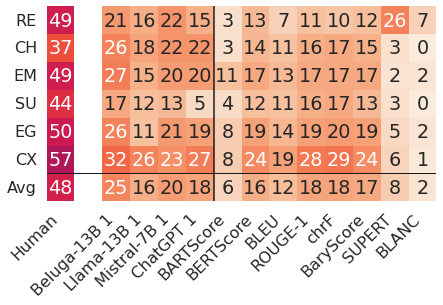

<Figure size 432x288 with 0 Axes>

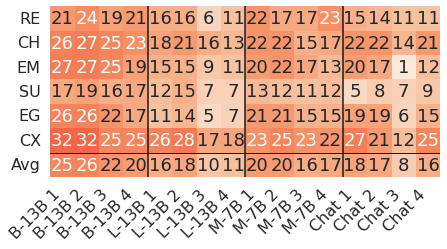

======= system =======
------ kendall ------


<Figure size 432x288 with 0 Axes>

<Figure size 3240x576 with 0 Axes>

<Figure size 3240x576 with 0 Axes>

<Figure size 3240x576 with 0 Axes>

<Figure size 3240x576 with 0 Axes>

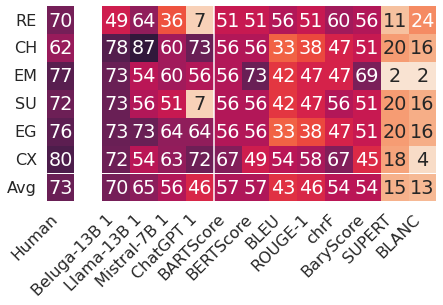

<Figure size 432x288 with 0 Axes>

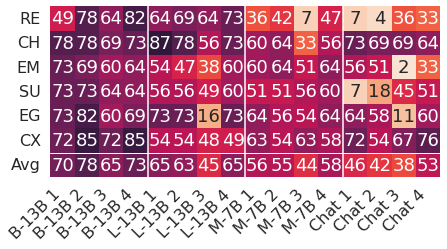

<Figure size 432x288 with 0 Axes>

In [44]:
# METRICS_FILTERED and CRITERIA
dico = {}
METRICS_FILTERED_CRITERIA_HEATMAPS_ALL = True
if METRICS_FILTERED_CRITERIA_HEATMAPS_ALL:
    for correlation_type in CORRELATION_TYPES:
        if correlation_type == "overall":
            line_color = "k"
        else:
            line_color = "w"
        dico[correlation_type] = {}
        print("======= {} =======".format(correlation_type))
        for Kstr in ['kendall']:
            print("------ {} ------".format(Kstr))
            dico[correlation_type]["Human"] = print_correlation_heatmap(correlation_type, Kstr, df=METRICS_DF_NO_HUMAN, 
                                  metrics_subset1=CRITERIA,
                                  metrics_subset2=METRICS_FILTERED,
                                  xticklabels=METRICS_FILTERED_LABELS,
                                  yticklabels=CRITERIA_LABELS+["Avg"],
                                  use_mask=True, font_scale=2, figsize=(45,8),
                                  savepath=None, returnCorr=True, use_pmask=False, show=False)
            for prefix in ["Human Avg 1", "Human Avg 2", "Human Avg 3"]:
                dico[correlation_type][prefix] = print_correlation_heatmap(correlation_type, Kstr, df=METRICS_DF_NO_HUMAN, 
                                  metrics_subset1=["{} {}".format(prefix, c).strip() for c in CRITERIA_LABELS],
                                  metrics_subset2=METRICS_FILTERED,
                                  xticklabels=METRICS_FILTERED_LABELS,
                                  yticklabels=CRITERIA_LABELS+["Avg"],
                                  use_mask=True, font_scale=2, figsize=(45,8),
                                  savepath=None, returnCorr=True, use_pmask=False, show=False)
            clean_corr = dico[correlation_type]["Human"].copy()
            for i in [1,2,3,4]:
                column = [dico[correlation_type]["Human"]["Beluga-13B {} {}".format(c, i)].iloc[j] for j, c in enumerate(CRITERIA_LABELS)]
                column.append(np.mean(column))
                clean_corr["Beluga-13B {}".format(i)] = column
                column = [dico[correlation_type]["Human"]["Llama-13B {} {}".format(c, i)].iloc[j] for j, c in enumerate(CRITERIA_LABELS)]
                column.append(np.mean(column))
                clean_corr["Llama-13B {}".format(i)] = column
                column = [dico[correlation_type]["Human"]["Mistral-7B {} {}".format(c, i)].iloc[j] for j, c in enumerate(CRITERIA_LABELS)]
                column.append(np.mean(column))
                clean_corr["Mistral-7B {}".format(i)] = column
                column = [dico[correlation_type]["Human"]["ChatGPT {} {}".format(c, i)].iloc[j] for j, c in enumerate(CRITERIA_LABELS)]
                column.append(np.mean(column))
                clean_corr["ChatGPT {}".format(i)] = column
            for i in [1,2,3]:
                column = [dico[correlation_type]["Human".format(i)]["Human {} {}".format(i, c)].iloc[j]  for j, c in enumerate(CRITERIA_LABELS)]
                column.append(np.mean(column))
                clean_corr["Human {}".format(i)] = column
            clean_corr["Human"] = np.round(np.mean([clean_corr["Human {}".format(i)] for i in [1,2,3]], axis=0))
            clean_corr[" "] = column
            clean_corr_all = clean_corr[METRICS_FILTERED_CLEAN_ALL].copy()
            print_correlation_heatmap(correlation_type, Kstr, df=METRICS_DF_NO_HUMAN, 
                                  metrics_subset1=["{} {}".format(prefix, c).strip() for c in CRITERIA_LABELS],
                                  metrics_subset2=METRICS_FILTERED_CLEAN_ALL,
                                  xticklabels=METRICS_FILTERED_LABELS_CLEAN_ALL,
                                  yticklabels=CRITERIA_LABELS+["Avg"],
                                  use_mask=True, font_scale=1.6, figsize=set_size(width),
                                  savepath="mixed1", save_svg=False, save_pdf=True, corr=clean_corr_all, returnCorr=True,
                                  colMask=1, colDividers=[6], rowDividers=[6], line_color=line_color, tickSize=16)
            clean_corr_short = clean_corr[METRICS_FILTERED_CLEAN_SHORT[2:]].copy()
            print_correlation_heatmap(correlation_type, Kstr, df=METRICS_DF_NO_HUMAN, 
                                  metrics_subset1=["{} {}".format(prefix, c).strip() for c in CRITERIA_LABELS],
                                  metrics_subset2=METRICS_FILTERED_CLEAN_SHORT[2:],
                                  xticklabels=METRICS_FILTERED_LABELS_CLEAN_SHORT[2:],
                                  yticklabels=CRITERIA_LABELS+["Avg"],
                                  use_mask=True, font_scale=1.5, figsize=set_size(width),
                                  savepath="mixed2", save_svg=False, save_pdf=True, corr=clean_corr_short, returnCorr=True,
                                  colDividers=[4,8,12], rowDividers=[6], line_color=line_color, tickSize=16)

## Williams

In [45]:
def get_williams_matrices(correlation_type, Kstr, metric1, df=METRICS_DF_NO_HUMAN, labels=METRICS, verbose1=False, verbose2=False):
    """returns the matrics containing the Williams test values"""
    data1 = np.array([json.loads(l) for l in df[metric1].tolist()]).T
    williams_t = np.zeros((len(labels), len(labels)))
    williams_p = np.zeros((len(labels), len(labels)))    
        
    for i, metric2 in enumerate(labels):
        r12 = get_correlation(correlation_type, Kstr, metric1, metric2, df=df, verbose=verbose2)
        for j, metric3 in enumerate(labels[:i]):
            if correlation_type == "system":
                n = data1.shape[1]
            elif correlation_type == "overall":
                n = data1.shape[0] * data1.shape[1]
            else:
                raise ValueError("Unknown correlation type")
            r13 = get_correlation(correlation_type, Kstr, metric1, metric3, df=df, verbose=verbose2)
            sign = np.sign(r12) * np.sign(r13)
            r12 = np.abs(r12)
            r13 = np.abs(r13)
            r23 = sign * get_correlation(correlation_type, Kstr, metric2, metric3, df=df, verbose=verbose2)
            if verbose1:
                print("{}, {}, {}, {}".format(r12, r13, r23, n))
            if n <= 3:
                t, p = 0, 0
                williams_t[i][j] = t
                williams_p[i][j] = p
            elif r12 == r13:
                t, p = 0, 0
                williams_t[i][j] = t
                williams_p[i][j] = p
            elif r12 > r13:
                t, p = williams_test(r12, r13, r23, n)
                williams_t[i][j] = t
                williams_p[i][j] = p
            elif r13 > r12:
                t, p = williams_test(r13, r12, r23, n)
                williams_t[j][i] = t
                williams_p[j][i] = p
            else:
                t, p = 0, 0
                williams_t[i][j] = t
                williams_p[i][j] = p
            if np.isnan(williams_p[i][j]):
                williams_p[i][j] = 0
            if np.isnan(williams_p[j][i]):
                williams_p[j][i] = 0
            if verbose1:
                print("2: {}, 3: {}, t: {}, p: {}".format(metric2, metric3, t, p))
    
    return williams_t, williams_p

In [46]:
def print_significance_heatmap(williams_p, labels=METRICS, font_scale=1.5, figsize=(40,40), save_path=None, row_mask=None, title=None, tickSize=None):
    sns.set(font_scale=font_scale)
    n, m = williams_p.shape
    fig, ax = plt.subplots(figsize=figsize)   
    cmap = matplotlib.colormaps["Greens_r"]
    if row_mask is not None:
        williams_p[row_mask] = 0
    annot = np.array([["{}".format(int(np.round(100*williams_p[i][j]))) if not (williams_p[i][j] == 0 or np.isnan(williams_p[i][j])) else "" for j in range(m) ] for i in range(n)])
    mask = np.isnan(williams_p) | (williams_p == 0)
    sns.heatmap(pd.DataFrame(williams_p, index=["{}".format(c) for c in CRITERIA_LABELS], columns=labels), vmin=0, vmax=0.3, mask=mask, linewidths=.5, annot=annot, square=True, fmt='', cmap=cmap, cbar=False, ax=ax)
    ax.set(ylabel='Beluga-13B 1')
    plt.xticks(fontsize=20, rotation=45, ha="right")
    plt.yticks(fontsize=20, rotation=0)
    if tickSize is not None:
        ax.tick_params(labelsize=tickSize)
    if title is not None:
        plt.title(title)
    plt.show()
    if save_path is not None:
        fig.savefig(save_path, format='png',bbox_inches='tight') 
        fig.savefig(save_path + ".pdf", format='pdf',bbox_inches='tight') 
    plt.clf()

hanna-benchmark-asg/williams.py:49: RuntimeWarning: invalid value encountered in sqrt
  denominator = np.sqrt(2*K*(n-1)/(n-3) + (((r12+r13)**2)/4)*((1-r23)**3))


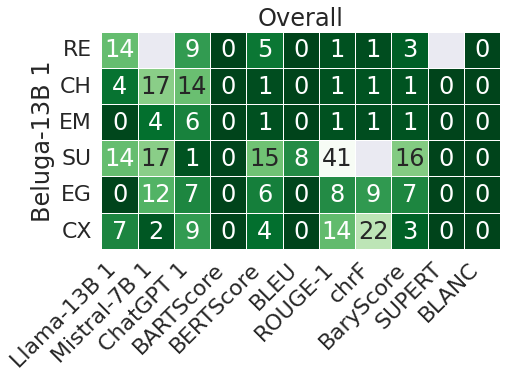

<Figure size 432x288 with 0 Axes>

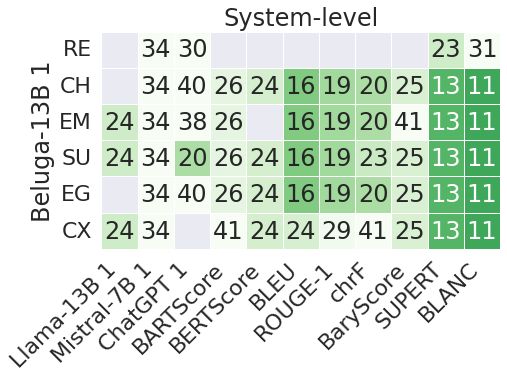

<Figure size 432x288 with 0 Axes>

In [47]:
# For each criterion, not average, DaVinci only
williams_dict = {}
for correlation_type in CORRELATION_TYPES:
    for c_i, c in enumerate(CRITERIA):
        METRICS_FILTERED_LABELS_GPT_CLEAN_C = ["Beluga-13B {} {}".format(CRITERIA_LABELS[c_i], i) for i in [1]] + ["Llama-13B {} {}".format(CRITERIA_LABELS[c_i], i) for i in [1]] + ["Mistral-7B {} {}".format(CRITERIA_LABELS[c_i], i) for i in [1]] + ["ChatGPT {} {}".format(CRITERIA_LABELS[c_i], i) for i in [1]] + [
            "BARTScore ΞΔ", "BERTScore Ξε", "BLEU Ξ§", "ROUGE-1 Ξ§",
            "chrF Ξ§", "BaryScore Ξε", "SUPERT ¤ε", "BLANC ¤Δ"
        ]
        williams_dict["{} {}".format(correlation_type, c)] = get_williams_matrices(correlation_type, "kendall", c, df=METRICS_FILTERED_DF_NO_HUMAN, labels=METRICS_FILTERED_LABELS_GPT_CLEAN_C, verbose1=False, verbose2=False)[1]
overall_stack = np.vstack([williams_dict["overall {}".format(c)][:1] for c in CRITERIA])
system_stack = np.vstack([williams_dict["system {}".format(c)][:1] for c in CRITERIA])
big_williams_p_story = false_discovery_control2(overall_stack)
big_williams_p_system = false_discovery_control2(system_stack)
METRICS_FILTERED_LABELS_GPT_CLEAN_C = ["Llama-13B 1", "Mistral-7B 1", "ChatGPT 1",
    "BARTScore", "BERTScore", "BLEU", "ROUGE-1",
    "chrF", "BaryScore", "SUPERT", "BLANC"
]
print_significance_heatmap(big_williams_p_story[:,1:], labels=METRICS_FILTERED_LABELS_GPT_CLEAN_C, font_scale=2, figsize=(8,4), title="Overall", save_path="figures/williams_kendall_story", tickSize=22)
print_significance_heatmap(big_williams_p_system[:,1:], labels=METRICS_FILTERED_LABELS_GPT_CLEAN_C, font_scale=2, figsize=(8,4), title="System-level", save_path="figures/williams_kendall_system", tickSize=22)

# User Study

In [48]:
EXPLANATIONS = pd.read_csv("user_study.csv")

In [49]:
ISSUES = ['Answer.a-1-guidelines.1',
       'Answer.a-2-syntax.1', 'Answer.a-3-superfluous.1',
       'Answer.a-4-incorrectness.1', 'Answer.a-5-unsubstantiated.1',
       'Answer.a-6-incoherence.1']

In [51]:
EXPLANATION_VALUES = EXPLANATIONS[['Answer.a-1-guidelines.1',
       'Answer.a-2-syntax.1', 'Answer.a-3-superfluous.1',
       'Answer.a-4-incorrectness.1', 'Answer.a-5-unsubstantiated.1',
       'Answer.a-6-incoherence.1']].to_numpy()

In [52]:
def compute_irr(explanation_values, issue_id, irr="cac", metric="nominal"):
    rater1 = explanation_values[::3, issue_id]
    rater2 = explanation_values[1::3, issue_id]
    rater3 = explanation_values[2::3, issue_id]
    data = np.vstack([rater1, rater2, rater3]).T
    df = pd.DataFrame(data, columns=["Rater 1", "Rater 2", "Rater 3"])
    cac2raters = CAC(df)
    irr_dict = {}
    irr_dict["fleiss"] = cac2raters.fleiss()
    irr_dict["gwet"] = cac2raters.gwet()
    irr_dict["krippendorff"] = cac2raters.krippendorff()
    irr_dict["conger"] = cac2raters.conger()
    irr_dict["bp"] = cac2raters.bp()
    print("Gwet AC1: {:.2f} ({:.2f}, {:.2f})".format(irr_dict["gwet"]["est"]["coefficient_value"], irr_dict["gwet"]["est"]["confidence_interval"][0], irr_dict["gwet"]["est"]["confidence_interval"][1]))
    return irr_dict

In [54]:
for i in range(6):
    if i != 3:
        print("===== {} =====".format(ISSUES[i]))
        compute_irr(EXPLANATION_VALUES, i, irr="cac")

===== Answer.a-1-guidelines.1 =====
Gwet AC1: 0.90 (0.85, 0.96)
===== Answer.a-2-syntax.1 =====
Gwet AC1: 0.97 (0.93, 1.00)
===== Answer.a-3-superfluous.1 =====
Gwet AC1: 0.66 (0.55, 0.78)
===== Answer.a-5-unsubstantiated.1 =====
Gwet AC1: 0.60 (0.47, 0.74)
===== Answer.a-6-incoherence.1 =====
Gwet AC1: 0.81 (0.73, 0.89)
